# **Klasifikasi Gambar Sayuran Menggunakan CNN**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan jenis sayuran.

## **Sumber Dataset:**
https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

**Nama:** Haykal Maulana Rulian

**ID Dicoding:** kaltralala

**Email:** themrhaykal@gmail.com

#**IMPORT LIBRARIES**

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


#**PERSIAPAN DATA**

## **Hubungkan Colab ke Akun Kaggle**

In [ ]:
# Upload kaggle.json ke Colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaltralala","key":"c0ae2cc8ff06299fb25814a91103ae31"}'}

In [ ]:
# Setup kaggle CLI di Colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## **Download Dataset Sayuran**

In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip -q vegetable-image-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 94% 504M/534M [00:06<00:00, 90.8MB/s]
100% 534M/534M [00:06<00:00, 81.8MB/s]


## **Cek Struktur Folder**

In [ ]:
import os

base_dir = "/content/Vegetable Images/train"
for split in os.listdir(base_dir):
    print(f"\n📂 {split.upper()}")
    split_path = os.path.join(base_dir, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            print(f"  - {label}: {num_images} gambar")


📂 CABBAGE

📂 CAPSICUM

📂 RADISH

📂 CARROT

📂 BROCCOLI

📂 POTATO

📂 PAPAYA

📂 BRINJAL

📂 BITTER_GOURD

📂 CUCUMBER

📂 PUMPKIN

📂 BOTTLE_GOURD

📂 BEAN

📂 CAULIFLOWER

📂 TOMATO


##**Membagi Dataset ke Train, Validation, dan Test**

In [ ]:
# Membagi dataset menjadi train, validation, dan test set (70%:15%:15%)

# Lokasi folder gambar asli (berisi subfolder per kelas)
base_dir = '/content/Vegetable Images/test'
new_base = 'vegetable_split'

# Daftar kelas berdasarkan nama folder
classes = os.listdir(base_dir)

# Melakukan split per kelas
for cls in classes:
    img_dir = os.path.join(base_dir, cls)
    imgs = os.listdir(img_dir)

    # 70% untuk training, 15% validation, 15% testing
    train_imgs, temp_imgs = train_test_split(imgs, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(new_base, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(img_dir, img)
            dst = os.path.join(split_dir, img)
            shutil.copy(src, dst)

##**Menyiapkan ImageDataGenerator untuk Augmentasi dan Preprocessing**

In [ ]:
# Membuat ImageDataGenerator untuk preprocessing dan augmentasi

# Augmentasi hanya pada data training
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation dan test tidak menggunakan augmentasi, hanya rescale
val_test_gen = ImageDataGenerator(rescale=1./255)

##**Membuat Data Loader (Flow from Directory)**

In [ ]:
# Membuat generator (data loader) dari folder hasil split

train_data = train_gen.flow_from_directory(
    'vegetable_split/train',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True  # Penting untuk melatih model
)

val_data = val_test_gen.flow_from_directory(
    'vegetable_split/val',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True  # Disarankan untuk menghindari urutan label tetap
)

test_data = val_test_gen.flow_from_directory(
    'vegetable_split/test',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False  # Tetap agar hasil evaluasi dan prediksi bisa dilacak
)

Found 2100 images belonging to 15 classes.
Found 450 images belonging to 15 classes.
Found 450 images belonging to 15 classes.


## **Visualisasi Contoh Gambar dari Setiap Kelas (Subset: Validation)**

Kode berikut digunakan untuk memvisualisasikan satu contoh gambar dari masing-masing kelas yang terdapat dalam dataset validation (`vegetable_split/val`). Visualisasi ini membantu memastikan distribusi dan representasi kelas dalam data.

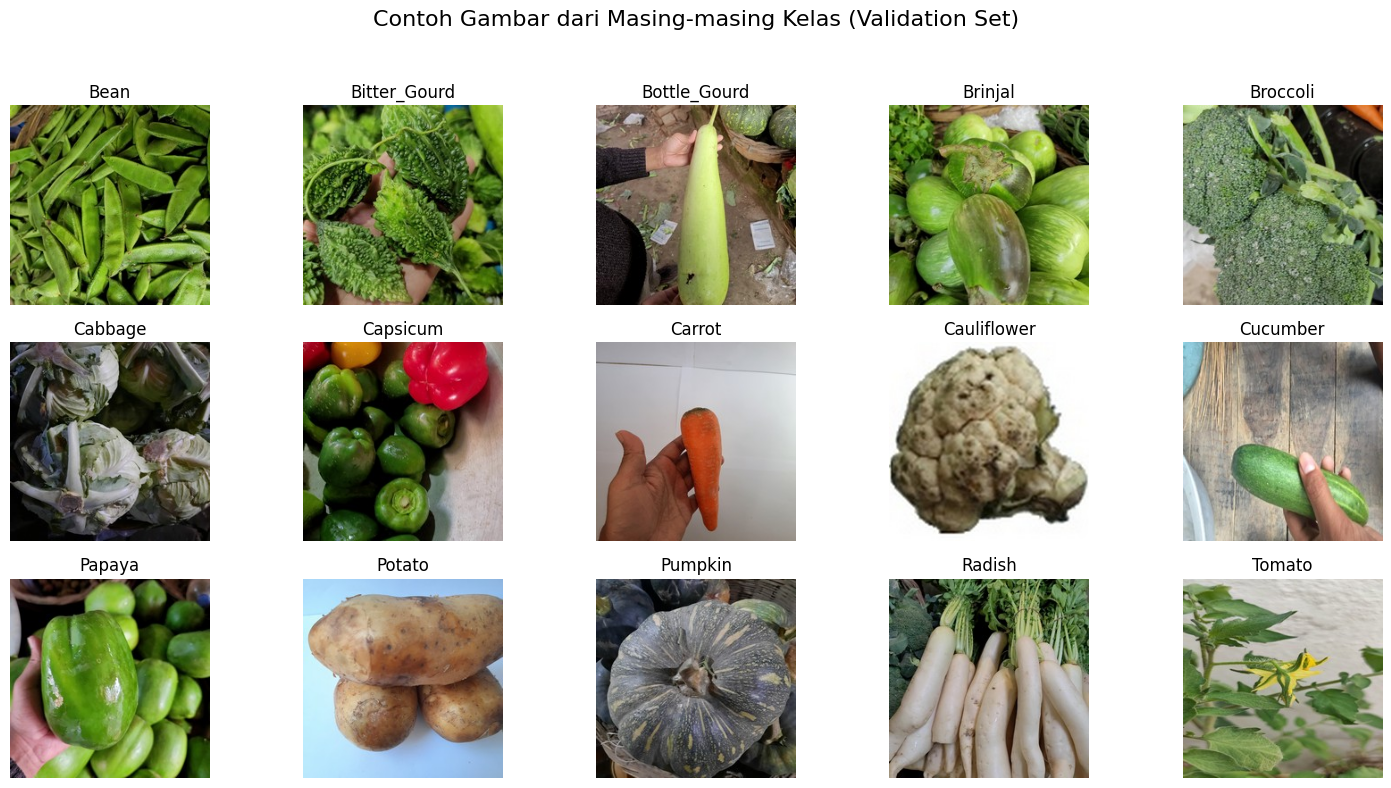

In [ ]:
# Direktori validation dataset
val_dir = 'vegetable_split/val'

# Ambil daftar kelas dari subfolder
class_names = sorted(os.listdir(val_dir))

# Inisialisasi list untuk path gambar per kelas
sample_image_paths = []

# Loop untuk ambil satu gambar dari tiap kelas
for class_name in class_names:
    class_dir = os.path.join(val_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        # Ambil 1 gambar secara acak dari kelas
        chosen_image = random.choice(image_files)
        sample_image_paths.append(os.path.join(class_dir, chosen_image))

# Visualisasi gambar
plt.figure(figsize=(15, 8))
for idx, img_path in enumerate(sample_image_paths):
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

plt.suptitle("Contoh Gambar dari Masing-masing Kelas (Validation Set)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##**Membangun Model Klasifikasi dengan Arsitektur CNN**

Pada bagian ini, dilakukan implementasi model *Convolutional Neural Network* (CNN) menggunakan arsitektur `Sequential` dari Keras, tanpa transfer learning. Model dikembangkan dari awal untuk melakukan ekstraksi fitur dan klasifikasi gambar sayuran.

Arsitektur model terdiri atas:

- **Input Layer** dengan ukuran (224, 224, 3),
- **4 blok Conv2D + MaxPooling2D** untuk ekstraksi fitur spasial:
  - 32 filter → 64 filter → 128 filter → 128 filter,
- **Flatten layer** untuk mengubah output konvolusi ke bentuk vektor 1 dimensi,
- **Dense layer** dengan 512 neuron dan aktivasi ReLU,
- **Dropout layer** (rate 0.5) untuk regularisasi dan mengurangi overfitting,
- **Output layer** dengan `num_classes` neuron dan aktivasi softmax.

Model dikompilasi dengan:
- Optimizer: `Adam`,
- Loss function: `categorical_crossentropy` (klasifikasi multikelas),
- Metrik evaluasi: `accuracy`.

Model ini cocok untuk pelatihan dari awal ketika tidak menggunakan fitur pre-trained.

In [ ]:
from tensorflow.keras.layers import Input

num_classes = len(train_data.class_indices)

model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# Set learning rate
optimizer = Adam(learning_rate=1e-4)  # misalnya 0.0001

# Compile ulang model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,686,223 (36.95 MB)

 Trainable params: 9,686,223 (36.95 MB)

 Non-trainable params: 0 (0.00 B)

##**Menentukan Callback untuk Early Stopping dan Checkpoint**

In [ ]:
# Menyimpan model terbaik berdasarkan penurunan val_loss selama pelatihan
checkpoint = ModelCheckpoint(
    'my_vegetable_model.h5',          # Nama file model yang akan disimpan
    monitor='val_loss',               # Metrik yang dipantau
    save_best_only=True,              # Hanya menyimpan model terbaik
    save_weights_only=False           # Menyimpan seluruh arsitektur dan bobot
)

# Menghentikan pelatihan lebih awal jika tidak ada perbaikan pada val_loss
early_stop = EarlyStopping(
    monitor='val_loss',               # Metrik yang dipantau
    patience=5,                       # Jumlah epoch tanpa perbaikan sebelum berhenti
    restore_best_weights=True         # Mengembalikan bobot terbaik ke model
)

##**Melatih Model dengan Validasi dan Callback**

In [ ]:
# Menentukan jumlah epoch pelatihan
epochs = 50

# Melatih model dengan data training dan validasi, serta menerapkan callback
history = model.fit(
    train_data,                        # Data pelatihan
    validation_data=val_data,          # Data validasi
    epochs=epochs,                     # Jumlah maksimum epoch
    callbacks=[early_stop, checkpoint] # Callback untuk kontrol pelatihan
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.0978 - loss: 2.6552

66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.0986 - loss: 2.6532 - val_accuracy: 0.3000 - val_loss: 2.0434
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.2551 - loss: 2.1597

66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 404ms/step - accuracy: 0.2555 - loss: 2.1584 - val_accuracy: 0.4156 - val_loss: 1.7500
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3428 - loss: 1.8859

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 418ms/step - accuracy: 0.3428 - loss: 1.8859 - val_accuracy: 0.4756 - val_loss: 1.5598
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.3856 - loss: 1.8028

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.3858 - loss: 1.8021 - val_accuracy: 0.4844 - val_loss: 1.4541
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4518 - loss: 1.6387

66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - accuracy: 0.4520 - loss: 1.6382 - val_accuracy: 0.6067 - val_loss: 1.2705
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4852 - loss: 1.4698

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.4852 - loss: 1.4698 - val_accuracy: 0.5822 - val_loss: 1.1750
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5088 - loss: 1.4361

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 423ms/step - accuracy: 0.5089 - loss: 1.4356 - val_accuracy: 0.6578 - val_loss: 1.0714
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5677 - loss: 1.2660

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step - accuracy: 0.5679 - loss: 1.2653 - val_accuracy: 0.6889 - val_loss: 0.9515
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6126 - loss: 1.1508

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.6125 - loss: 1.1510 - val_accuracy: 0.7311 - val_loss: 0.8578
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6299 - loss: 1.0494

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.6300 - loss: 1.0496 - val_accuracy: 0.7578 - val_loss: 0.8047
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6444 - loss: 1.0426

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.6444 - loss: 1.0427 - val_accuracy: 0.7711 - val_loss: 0.7227
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.6635 - loss: 0.9943 - val_accuracy: 0.7400 - val_loss: 0.7758
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6829 - loss: 0.9622

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.6830 - loss: 0.9617 - val_accuracy: 0.7933 - val_loss: 0.6703
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6846 - loss: 0.9328

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step - accuracy: 0.6849 - loss: 0.9319 - val_accuracy: 0.7867 - val_loss: 0.6170
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7061 - loss: 0.8611

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 418ms/step - accuracy: 0.7061 - loss: 0.8613 - val_accuracy: 0.8111 - val_loss: 0.6101
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 416ms/step - accuracy: 0.6863 - loss: 0.8994 - val_accuracy: 0.8111 - val_loss: 0.6184
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - accuracy: 0.7342 - loss: 0.8022 - val_accuracy: 0.7356 - val_loss: 0.7332
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7266 - loss: 0.7608

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 416ms/step - accuracy: 0.7266 - loss: 0.7610 - val_accuracy: 0.7978 - val_loss: 0.5761
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.7357 - loss: 0.7570 - val_accuracy: 0.8244 - val_loss: 0.5934
Epoch 20/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.7625 - loss: 0.6853 - val_accuracy: 0.8111 - val_loss: 0.6308
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7496 - loss: 0.7114

66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 434ms/step - accuracy: 0.7496 - loss: 0.7115 - val_accuracy: 0.8067 - val_loss: 0.5696
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7620 - loss: 0.7140

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - accuracy: 0.7623 - loss: 0.7135 - val_accuracy: 0.8489 - val_loss: 0.5298
Epoch 23/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7735 - loss: 0.6561

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.7735 - loss: 0.6563 - val_accuracy: 0.8511 - val_loss: 0.4819
Epoch 24/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7752 - loss: 0.6679

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.7752 - loss: 0.6678 - val_accuracy: 0.8622 - val_loss: 0.4686
Epoch 25/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7776 - loss: 0.6443

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 424ms/step - accuracy: 0.7776 - loss: 0.6443 - val_accuracy: 0.8667 - val_loss: 0.4270
Epoch 26/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.7869 - loss: 0.6167 - val_accuracy: 0.8667 - val_loss: 0.4409
Epoch 27/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.8103 - loss: 0.5821 - val_accuracy: 0.8711 - val_loss: 0.4346
Epoch 28/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8074 - loss: 0.5922

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.8072 - loss: 0.5924 - val_accuracy: 0.8733 - val_loss: 0.3806
Epoch 29/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.8269 - loss: 0.5607 - val_accuracy: 0.8911 - val_loss: 0.4044
Epoch 30/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step - accuracy: 0.8073 - loss: 0.5940 - val_accuracy: 0.8556 - val_loss: 0.4651
Epoch 31/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - accuracy: 0.8018 - loss: 0.5901 - val_accuracy: 0.8844 - val_loss: 0.3874
Epoch 32/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8170 - loss: 0.5190

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step - accuracy: 0.8170 - loss: 0.5193 - val_accuracy: 0.9044 - val_loss: 0.3477
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 420ms/step - accuracy: 0.8252 - loss: 0.5581 - val_accuracy: 0.8911 - val_loss: 0.3845
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8347 - loss: 0.5233

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.8346 - loss: 0.5237 - val_accuracy: 0.8911 - val_loss: 0.3452
Epoch 35/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.8544 - loss: 0.4621 - val_accuracy: 0.8778 - val_loss: 0.3846
Epoch 36/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8281 - loss: 0.5212

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.8281 - loss: 0.5215 - val_accuracy: 0.8978 - val_loss: 0.3388
Epoch 37/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step - accuracy: 0.8686 - loss: 0.4206 - val_accuracy: 0.9067 - val_loss: 0.3454
Epoch 38/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8479 - loss: 0.4618

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.8478 - loss: 0.4621 - val_accuracy: 0.8956 - val_loss: 0.3185
Epoch 39/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8340 - loss: 0.4964

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 427ms/step - accuracy: 0.8340 - loss: 0.4960 - val_accuracy: 0.9111 - val_loss: 0.3161
Epoch 40/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8410 - loss: 0.4514

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 410ms/step - accuracy: 0.8410 - loss: 0.4517 - val_accuracy: 0.9200 - val_loss: 0.2943
Epoch 41/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.8632 - loss: 0.4547 - val_accuracy: 0.8644 - val_loss: 0.4317
Epoch 42/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.8565 - loss: 0.4281 - val_accuracy: 0.8778 - val_loss: 0.3779
Epoch 43/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.8424 - loss: 0.4343 - val_accuracy: 0.8911 - val_loss: 0.3809
Epoch 44/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.8641 - loss: 0.4005 - val_accuracy: 0.9244 - val_loss: 0.3137
Epoch 45/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8581 - loss: 0.4003

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 419ms/step - accuracy: 0.8581 - loss: 0.4007 - val_accuracy: 0.9289 - val_loss: 0.2839
Epoch 46/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8673 - loss: 0.4126

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 420ms/step - accuracy: 0.8673 - loss: 0.4125 - val_accuracy: 0.9222 - val_loss: 0.2823
Epoch 47/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step - accuracy: 0.8697 - loss: 0.3720 - val_accuracy: 0.9133 - val_loss: 0.3172
Epoch 48/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8680 - loss: 0.3928

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.8679 - loss: 0.3929 - val_accuracy: 0.9333 - val_loss: 0.2558
Epoch 49/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step - accuracy: 0.8713 - loss: 0.3868 - val_accuracy: 0.9222 - val_loss: 0.2994
Epoch 50/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.8802 - loss: 0.3928 - val_accuracy: 0.9044 - val_loss: 0.2980


#**EVALUASI MODEL**

##**Evaluasi Akurasi Model dan Visualisasi Kurva**

Test Accuracy: 91.78%


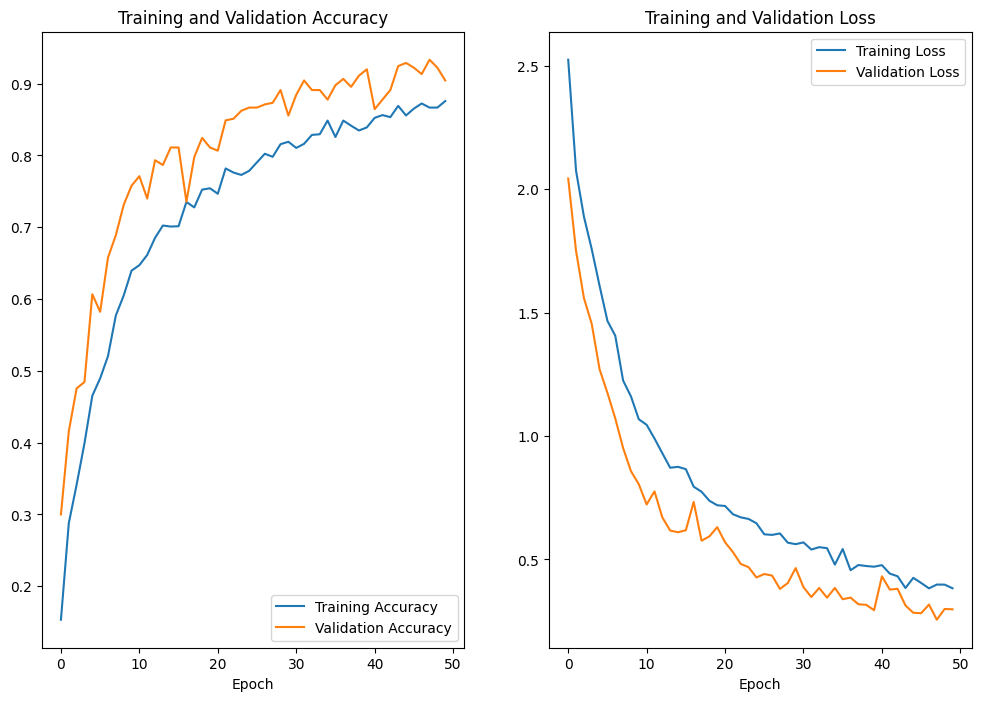

In [ ]:
# Menghitung akurasi model pada data uji
scores = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {'%.2f%%' % (scores[1]*100)}")

# Mengambil data akurasi dan loss dari training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Menampilkan kurva akurasi dan loss antara training dan validation
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

##**Membuat dan Menampilkan Confusion Matrix**

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


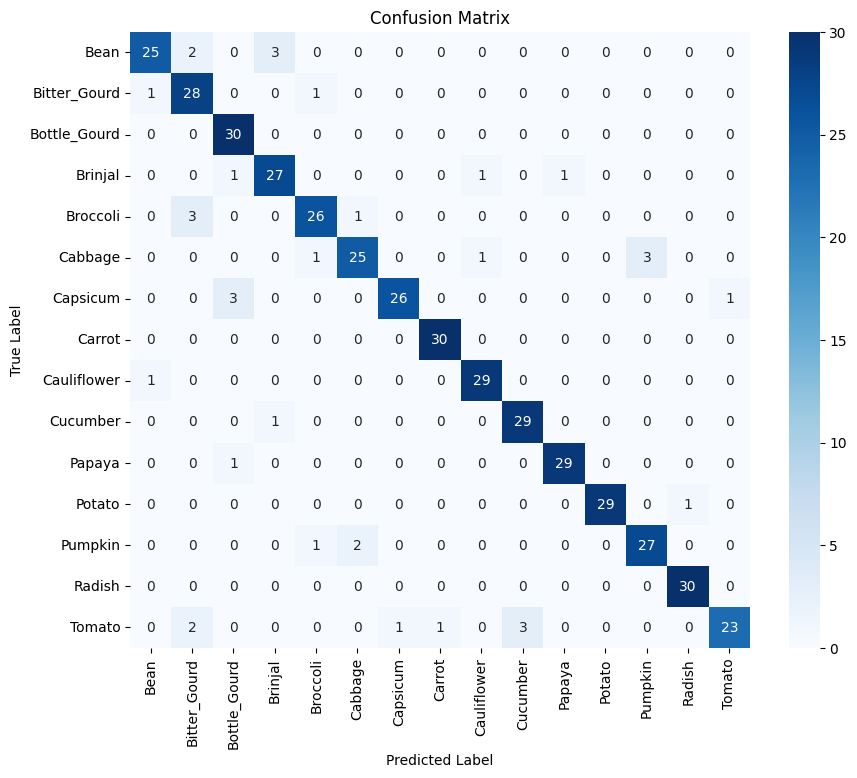

In [ ]:
# Prediksi pada data test
test_predictions = model.predict(test_data)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Mendapatkan true labels dari test data generator
test_true_labels = test_data.classes

# Mendapatkan nama kelas
class_labels = list(test_data.class_indices.keys())

# Membuat Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions_classes)

# Menampilkan Confusion Matrix dengan nama kelas
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##**Menampilkan Classification Report**

In [ ]:
# Membuat Classification Report
class_report = classification_report(test_true_labels, test_predictions_classes, target_names=class_labels)

# Menampilkan Classification Report
print("\nClassification Report:\n")
class_report


Classification Report:



'              precision    recall  f1-score   support\n\n        Bean       0.93      0.83      0.88        30\nBitter_Gourd       0.80      0.93      0.86        30\nBottle_Gourd       0.86      1.00      0.92        30\n     Brinjal       0.87      0.90      0.89        30\n    Broccoli       0.90      0.87      0.88        30\n     Cabbage       0.89      0.83      0.86        30\n    Capsicum       0.96      0.87      0.91        30\n      Carrot       0.97      1.00      0.98        30\n Cauliflower       0.94      0.97      0.95        30\n    Cucumber       0.91      0.97      0.94        30\n      Papaya       0.97      0.97      0.97        30\n      Potato       1.00      0.97      0.98        30\n     Pumpkin       0.90      0.90      0.90        30\n      Radish       0.97      1.00      0.98        30\n      Tomato       0.96      0.77      0.85        30\n\n    accuracy                           0.92       450\n   macro avg       0.92      0.92      0.92       450\nweigh

Dengan membagi evaluasi menjadi tiga cell ini, mempermudah pembacaan hasil dan debugging jika diperlukan. Evaluasi mencakup metrik kuantitatif (akurasi), visual (kurva dan confusion matrix), dan klasifikasi per kelas (classification report), sehingga lengkap dan komprehensif.

##**Definisi Fungsi Visualisasi Klasifikasi Gambar**

In [ ]:
# Fungsi untuk memuat, mengklasifikasikan, dan menampilkan gambar
def classify_and_display_image(model, img_path, class_names):
    """
    Fungsi ini memuat gambar dari path, melakukan prediksi menggunakan model yang telah dilatih,
    dan menampilkan hasil klasifikasi secara visual.

    Args:
        model: Model Keras yang telah dilatih.
        img_path: Path ke gambar input.
        class_names: List dari semua nama kelas berdasarkan urutan indeks prediksi.
    """
    # Load dan preprocess gambar
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi seperti data pelatihan

    # Prediksi
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]

    # Label sebenarnya berdasarkan nama folder
    true_class_name = os.path.basename(os.path.dirname(img_path))

    # Evaluasi apakah prediksi benar
    is_correct = predicted_class_name == true_class_name

    # Tampilkan hasil
    plt.imshow(img)
    plt.title(f"{predicted_class_name} (Correct: {is_correct})")
    plt.axis('off')

##**Menampilkan 15 Gambar Acak dan Hasil Prediksi**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


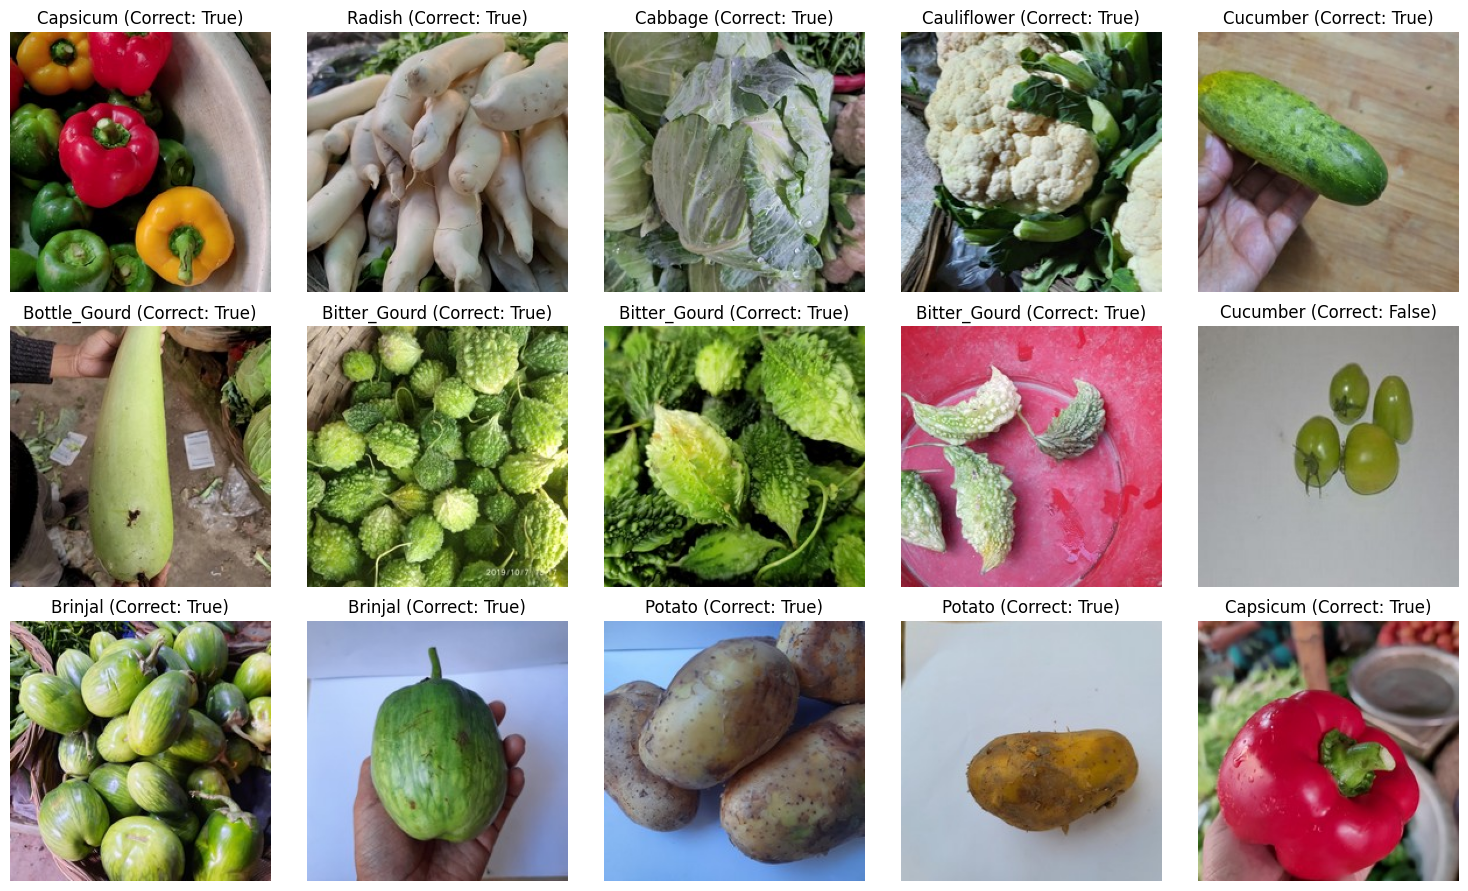

In [ ]:
# Daftar nama kelas dari generator test
class_names = list(test_data.class_indices.keys())

# Mengambil path semua gambar dari direktori test
test_image_paths = []
for root, _, files in os.walk('vegetable_split/test'):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths.append(os.path.join(root, file))

# Pilih 15 gambar secara acak
random_image_paths = random.sample(test_image_paths, min(15, len(test_image_paths)))

# Tampilkan hasil klasifikasi dalam grid 3x5
plt.figure(figsize=(15, 9))
for i, img_path in enumerate(random_image_paths):
    plt.subplot(3, 5, i + 1)
    classify_and_display_image(model, img_path, class_names)

plt.tight_layout()
plt.show()

Visualisasi ini membantu menilai performa model secara kualitatif, bukan hanya numerik. Dengan membandingkan prediksi dan label sebenarnya secara visual, agar bisa mengidentifikasi apakah model hanya menghafal pola tertentu atau benar-benar belajar mengenali fitur visual sayuran.

#**Simpan & Ekspor Model**

In [ ]:
model.export('saved_model/my_vegetable_model')
print("Model berhasil disimpan dalam format SavedModel")

Saved artifact at 'saved_model/my_vegetable_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  140194245551184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194245554640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270809552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270813200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270806480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270813968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270815120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270814352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270812816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270812432: TensorSpec(shape=(), dtype=tf.resource, name=None

In [ ]:
# Mengubah model Keras menjadi format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengkonversi model
tflite_model = converter.convert()

# Menyimpan model TFLite
with open('my_vegetable_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi dan disimpan dalam format TensorFlow Lite (.tflite)")

Saved artifact at '/tmp/tmp8_4mfhz4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  140194245551184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194245554640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270809552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270813200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270806480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270813968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270815120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270814352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270812816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140194270812432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401942708

In [ ]:
import tensorflowjs as tfjs

# Convert the SavedModel to TensorFlow.js layers format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    saved_model/my_vegetable_model \
    tfjs_model/

print("Model berhasil dikonversi dan disimpan dalam format TensorFlow.js (layers format)")

2025-06-22 03:06:50.533444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750561610.553548   12244 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750561610.559429   12244 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-22 03:06:55.437677: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1750561615.437850   12244 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
pip freeze > requirements.txt

In [ ]:
# Compress the folders
!zip -r saved_model.zip saved_model/
!zip -r tfjs_model.zip tfjs_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_vegetable_model/ (stored 0%)
  adding: saved_model/my_vegetable_model/saved_model.pb (deflated 86%)
  adding: saved_model/my_vegetable_model/variables/ (stored 0%)
  adding: saved_model/my_vegetable_model/variables/variables.index (deflated 63%)
  adding: saved_model/my_vegetable_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_vegetable_model/fingerprint.pb (stored 0%)
  adding: saved_model/my_vegetable_model/assets/ (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard10of10.bin (deflated 8%)
  adding: tfjs_model/group1-shard7of10.bin (deflated 8%)
  adding: tfjs_model/group1-shard5of10.bin (deflated 8%)
  adding: tfjs_model/group1-shard9of10.bin (deflated 8%)
  adding: tfjs_model/group1-shard8of10.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 90%)
  adding: tfjs_model/group1-shard4of10.bin (deflated 8%)
  adding: tfjs_model/group1-shard2of10.bin (de